In [ ]:
import re
import time
import json
import requests
from collections import Counter
from datetime import datetime, timedelta
import itertools
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from collections import Counter
from ruwordnet import RuWordNet


# Скачиваем посты группы ВК [Насилие в родах](https://vk.com/humanize_birth)

In [ ]:
link = 'your_link_here'

In [ ]:
ACCESS_TOKEN = re.search(r'(?<=access_token=)[^&]+', link).group(0)
GROUP_DOMAIN = 'humanize_birth'
API_VERSION = '5.199'
MAX_COUNT = 100  # VK limit per call

In [ ]:
def fetch_all_posts(group_domain):
    """Fetch all wall posts from the group"""
    all_posts = pd.DataFrame()
    offset = 0

    while True:
        params = {
            'access_token': ACCESS_TOKEN,
            'v': API_VERSION,
            'domain': group_domain,
            'offset': offset,
            'count': MAX_COUNT,
            'filter': 'owner'
        }
        response = requests.get('https://api.vk.com/method/wall.get', params=params).json()

        # Check if there are no more posts to fetch
        items = response.get('response', {}).get('items', [])
        if not items:
            break

        for item in items:
            epoch_time = item['date']
            utc_plus_3_time = datetime.utcfromtimestamp(epoch_time) + timedelta(hours=3)
            formatted_time = utc_plus_3_time.strftime('%Y-%m-%d %H:%M:%S')
            all_posts = pd.concat([
                all_posts,
                pd.DataFrame([{
                    'text': item.get('text', ''),
                    'date': formatted_time,
                    'id': item.get('id', ''),
                    'signer_id': item.get('signer_id', None)
                }])
            ], ignore_index=True)

        offset += MAX_COUNT  # Increment offset to fetch the next batch

        # Optional: Add a delay to avoid hitting API rate limits
        time.sleep(0.5)

    return all_posts

In [ ]:
data = fetch_all_posts(GROUP_DOMAIN)
data.to_csv('humanize_birth_testimonies.csv', index=False)

## Осмотр данных

In [ ]:
violence = pd.read_csv('../data/obstetric violence categories.csv')
data = pd.read_csv('../output/humanize_birth_testimonies.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
data['text'] = data['text'].astype(str)
data['text'] = data['text'].str.replace(r'\n', '', regex=True)
# data['text'] = data['text'].str.replace(r'\s+', '', regex=True)
data['post_length'] = data['text'].apply(lambda x: len(str(x).split()))

In [ ]:
# Extract the list of hashtags from the violence DataFrame
violence_hashtags = violence['hashtag'].tolist()

# Function to extract matching hashtags from a post
def extract_hashtags(post_text):
    if not isinstance(post_text, str):  # Ensure the input is a string
        return []
    return [hashtag for hashtag in re.findall(r'#\w+', post_text) if hashtag in violence_hashtags]

# Apply the function to the 'text' column and create a new column for matching hashtags
data['hashtags'] = data['text'].apply(extract_hashtags)
data['hashtags'] = data['hashtags'].apply(lambda x: None if isinstance(x, list) and not x else x)

# Display the updated DataFrame
data[['text', 'hashtags']].head()

,text,hashtags
0,#модераторское@humanize_birthПаблик закрыт. Ис...,[#модераторское]
1,"Здравствуйте! Меня зовут Анна, я студентка 6 к...",[#насилие_в_родах]
2,Тут будет две истории;)Старшую дочь я рожала в...,[]
3,"Анонимно пожалуйста 🙏 Мне 22 года, ребеночку с...",[#насилие_в_родах]
4,Первородка. Родила дочь в 2018. Наблюдалась в ...,[]


In [ ]:
# Function to find the type of violence for each post
hashtag_to_category = dict(zip(violence['hashtag'], violence['category']))

def find_violence_type(post_hashtags):
    if not post_hashtags:
        return None
    categories = {hashtag_to_category[hashtag] for hashtag in post_hashtags if hashtag in hashtag_to_category}
    return ', '.join(categories) if categories else None

data['violence_type'] = data['hashtags'].apply(find_violence_type)

# Выделяем эмоции в постах [Насилие в родах](https://vk.com/humanize_birth)

In [4]:
russian_stopwords = set(stopwords.words("russian"))
morph = MorphAnalyzer()
nltk.download('punkt')
tqdm.pandas()
wn = RuWordNet()

[nltk_data] Downloading package punkt to /Users/Helen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('../output/detailed_data_with_emotions.csv')
# violence = pd.read_csv('../output/obstetric violence categories.csv')

In [8]:
# Replace all occurrences of 'non-physical' in the 'violence_type' column with 'psychological'
df['violence_type'] = df['violence_type'].str.replace('non-physical', 'psychological', regex=False)

## Словарь эмоций

In [ ]:
# Словарь для определения эмоций, созданный на основе синонимов из RuWordNet и ручного редактирования
emotion_lexicon = {
    'стыд': {'виноватый', 'вина', 'унижение','униженность', 'позор', 'стыд', 'клеймо', 'смущенность', 'пристыженный', 'смущение', 'стыдоба', 'смутить', 'сконфузить', 'оконфузить', 'конфузить', 'оконфуживать', 'стыдливость', 'смущать', 'позорище', 'бесчестье', 'стыдно', 'позор', 'пятно'},
    'страх': {'истерика', 'нервничать', 'жуть', 'болевой', 'панический', 'волнение', 'стресс', 'запугивание', 'ад','бояться','страх', 'чувство волнения', 'тревога', 'кошмарные обстоятельства', 'жуть', 'страшенный', 'боязнь', 'тревога', 'волнение', 'ажитация', 'ужас', 'беспокойность', 'встревоженность', 'мрак', 'жуткий', 'взволнованность', 'треволнение', 'беспокойство', 'страшный', 'страх', 'обеспокоенность', 'паника', 'тревожность', 'ужас', 'опасение'},
    'боль': {'удар', 'мучиться', 'дискомфорт', 'скулить', 'выть', 'мучаться', 'болевой', 'жечь', 'голод', 'изжога', 'жжение', 'пытка', 'мука','плакать','рана', 'боль', 'болевой', 'разболеться', 'переболеть', 'болевое ощущение', 'нестерпимый', 'рана души', 'болеть', 'страдание', 'нездоровый', 'поболеть', 'слабенький', 'заболеть', 'приболеть', 'нездоровиться', 'хворать', 'заболевать', 'слабый', 'побаливать', 'страдание', 'проболеть', 'похварывать', 'недомогать', 'мука', 'нещадный', 'невыносимый', 'мучение', 'болезненный', 'слабоватый', 'прихварывать', 'мученичество', 'ослабелый', 'больно', 'боль', 'непереносимый'},
    'злость': {'ненависть', 'злость', 'злоба', 'гнев', 'озлобленность', 'злоба', 'злость', 'ожесточение', 'агрессивность', 'раздраженность', 'остервенелость', 'агрессия', 'бешенство', 'неистовость', 'озлобление', 'яростность', 'злобность', 'ярость', 'раздражение', 'ожесточенность', 'ополчать'},
    'одиночество': {'непонимание', 'безразличный', 'одиночество', 'беспомощность', 'никто', 'изолированность', 'изоляция', 'изолирование', 'отчуждение собственности', 'один'},
    'грусть': {'реветь', 'подвывать', 'навзрыд', 'отчаяние', 'расплакаться', 'безысходность', 'грустно','грустить', 'расстройство', 'тоскливость', 'взгрустнуть', 'грустноватый', 'грусть', 'минор', 'скисать', 'опечалиться', 'огорчение', 'тоска', 'опечаливаться', 'грустный', 'погрустить', 'невеселый', 'печальный', 'печаль', 'печалиться', 'погрустнеть', 'сокрушенный', 'хандра', 'грустить', 'меланхолия', 'скиснуть', 'нерадостный', 'загрустить', 'депрессия'},
    'радость': {'наслаждаться','улыбаться', 'радоваться', 'поздравлять', 'счастье', 'восторг', 'восхититься', 'нарадоваться', 'восхищение', 'порадоваться', 'радость', 'восторженный', 'восторгаться', 'обрадоваться', 'праздник', 'отрада', 'радоваться', 'возрадоваться', 'восхищаться', 'радостный'},
    'спокойствие': {'облегчение', 'спокойно', 'приветливый', 'добродушный', 'подбадривать', 'спокойный', 'спокойствие', 'умиротворенный', 'умиротворить', 'умиротворение', 'покой', 'умиротворять', 'равновесие'},
    'унижение': {'пренебрежение', 'оскорбление', 'осуждение', 'униженность', 'уничижить', 'срамиться', 'стыд', 'клеймо', 'оскандалиться', 'уничижать', 'стыдоба', 'опозориться', 'запачкаться', 'принизить', 'унижение', 'осрамиться', 'пощечина', 'принижение', 'замараться', 'унижать', 'самоуничижение', 'уничижение', 'самоунижение', 'унизить', 'позорище', 'бесчестье', 'позориться', 'пятно', 'принижать', 'позор'}#,
    # 'отвращение': {'раздражать', 'противно', 'покоробить', 'отвратить', 'отвращать', 'ужасный', 'пренеприятный', 'отпихнуть', 'омерзение', 'отталкивать', 'мерзкий', 'чудовищный', 'отвратительный', 'отпугнуть', 'отпугивать', 'упредить', 'претить', 'тошный', 'жутчайший', 'поганый', 'предотвращать', 'отталкивающий', 'мерзостный', 'жуткий', 'пакостный', 'фиговый', 'оттолкнуть', 'безобразный', 'пренеприятнейший', 'омерзительный', 'отпихивать', 'гнусный', 'предотвратить', 'гадкий', 'предупреждать', 'отвратный', 'дерьмовый', 'мерзопакостный', 'малоприятный', 'тошнота', 'отвращение', 'отстойный', 'противный', 'неприятный', 'коробить', 'паскудный', 'тошнотворный', 'гадостный', 'скверный'},
    # 'разочарование': {'расстройство', 'огорчение', 'разочарование', 'разочарованность', 'минорное настроение'},
    # 'беспомощность': {'беспомощность', 'неспособный защитить себя', 'беззащитный', 'беспомощный', 'беззащитность'},
    # 'недовольный': {'недовольный', 'недовольство', 'неудовольствие'},
    # 'агрессия': {'обозвать','обзывать', 'агрессия', 'агрессивное состояние', 'агрессивный', 'агрессивность'},
}

In [ ]:
# Adding synonyms from RuWordNet dynamically
def extend_lexicon_with_ruwordnet(emotion, words):
    for word in words:
        new_synonyms = set()  # Temporary set to collect new synonyms
        for sense in wn.get_senses(word):
            synonyms = [synonym.name for synonym in sense.synset.senses]
            new_synonyms.update(synonyms)
        emotion_lexicon[emotion].update(new_synonyms)  # Update the original set after iteration

# Extend lexicon for all emotions
for key in list(emotion_lexicon.keys()):  # Create a copy of the keys to avoid modifying the dictionary during iteration
    extend_lexicon_with_ruwordnet(key, list(emotion_lexicon[key]))  # Pass a copy of the set to avoid runtime errors

In [81]:
emotion_lexicon.items()

dict_items([('стыд', {'оконфузить', 'смущать', 'позорище', 'унижение', 'привести в замешательство', 'смутить', 'привести в смущение', 'позор', 'смущенность', 'чувство стыда', 'бесчестье', 'клеймо позора', 'оконфуживать', 'пятно на совести', 'пристыженный', 'клеймо', 'смущение', 'сконфузить', 'стыд', 'пятно бесчестья', 'пятно', 'стыдно', 'какой позор', 'пятно позора', 'приводить в смущение', 'стыдоба', 'стыдливость', 'к стыду своему', 'клеймо на репутации', 'позорное клеймо', 'конфузить', 'пятно на репутации', 'униженность'}), ('страх', {'кошмарные обстоятельства', 'мрак', 'большая тревога', 'встревоженность', 'треволнение', 'страшенный', 'волнение', 'тихий ужас', 'жуть', 'стеснение в сердце', 'кошмар', 'чувство тревоги', 'ужасная ситуация', 'обеспокоенность', 'беспокойство', 'волнения', 'кошмарная ситуация', 'тревожность', 'беспокойность', 'тревожный сигнал', 'как в страшном сне', 'паника', 'сигнал тревоги', 'бояться', 'в страшном сне', 'ад', 'ужас', 'жуткий', 'как о страшном сне', 'чу

## Считаем эмоции в постах

In [13]:
# Drop rows with NaN in 'violence_type' before applying the filter
df = df.loc[~df['violence_type'].str.contains('admin')]

In [11]:
df['clean_text'] = df['text'].str.replace(r'#[\w_]+(@humanize_birth)', ' ', regex=True)
df['clean_text'] = df['clean_text'].str.replace(r'#[\w_]+', ' ', regex=True)
# df.loc[df['id'] == 2553, 'clean_text'].to_clipboard()

In [12]:
def preprocess(text):
    text = re.sub(r'[^а-яА-ЯёЁ\s]', ' ', text.lower())
    text = re.sub(r'\s{2,}', ' ', text.lower())
    tokens = nltk.word_tokenize(text, language='russian')
    lemmas = [morph.parse(word)[0].normal_form for word in tokens if word.isalpha()]
    lemmas = [word for word in lemmas if word not in russian_stopwords and len(word) > 1]
    return lemmas

df['lemmas'] = df['clean_text'].progress_apply(preprocess)

100%|██████████| 914/914 [02:05<00:00,  7.29it/s]


In [13]:
def emotion_share(lemmas):
    total = len(lemmas)
    counts = {emotion: 0 for emotion in emotion_lexicon}
    
    for lemma in lemmas:
        for emotion, word_set in emotion_lexicon.items():
            if lemma in word_set:
                counts[emotion] += 1
    
    # Convert counts to shares
    if total == 0:
        shares = {emotion: 0.0 for emotion in emotion_lexicon}
    else:
        shares = {emotion: count / total for emotion, count in counts.items()}
    
    return shares

df['emotion_shares'] = df['lemmas'].progress_apply(emotion_share)

100%|██████████| 914/914 [00:00<00:00, 2817.06it/s]


## Визуализируем эмоции

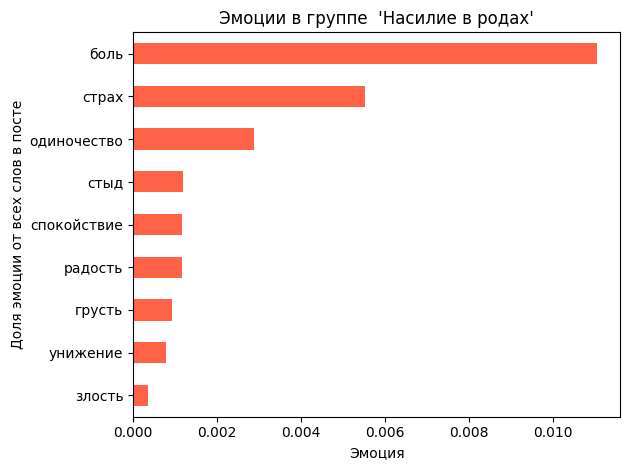

In [18]:
import matplotlib.pyplot as plt

emotion_columns = list(emotion_lexicon.keys())
df[emotion_columns] = df['emotion_shares'].apply(pd.Series)
emotion_df = df[emotion_columns]

# Calculate the mean of each emotion
mean_emotions = emotion_df.mean().sort_values(ascending=True)

# Plot the results
mean_emotions.plot(kind='barh', color='tomato')
plt.ylabel("Доля эмоции от всех слов в посте")
plt.xlabel("Эмоция")
plt.title("Эмоции в группе  'Насилие в родах'")
plt.tight_layout()
plt.show()


In [4]:
# Preparing data for co-occurence of hashtags and violence types
psychological_tags = [
    '#ирония_унижение_обесценивание',
    '#игнор_просьб_о_помощи',
    '#игнор_боли',
    '#вопреки_отказу',
    '#сознательная_дезинформация_обман',
    '#принуждение_к_кесареву_сечению',
]

physical_tags = [
    '#нельзя_свободно_двигаться',
    '#кесарево_сечение',
    '#болезненный_осмотр',
    '#выдавливание_кристеллер',
    '#прокол_пузыря',
    '#стимуляция_и_принуждение_к_ней',
    '#ручное_открытие_шейки',
    '#швы_на_живую',
    '#швы_наживую',
    '#эпизиотомия'
]

all_tags = psychological_tags + physical_tags

# Ensure df['hashtags'] is a list
df['hashtags'] = df['hashtags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Create binary columns for each hashtag
for tag in all_tags:
    df[tag] = df['hashtags'].apply(lambda tags: int(tag in tags))


# Subset to only the relevant columns
psychological_df = df[psychological_tags]
physical_df = df[physical_tags]

co_occurrence_matrix = psychological_df.T.dot(physical_df)

# Save or inspect the matrix
co_occurrence_matrix.to_csv("cooccurrence_matrix_psych_vs_phys.csv")

# Optional: Normalize
# co_occurrence.to_csv('hashtag_heatmap.csv')


In [8]:
psychological_df.sum()

#ирония_унижение_обесценивание       586
#игнор_просьб_о_помощи               438
#игнор_боли                          416
#вопреки_отказу                       89
#сознательная_дезинформация_обман    182
#принуждение_к_кесареву_сечению       58
dtype: int64

In [9]:
physical_df.sum()

#нельзя_свободно_двигаться         215
#кесарево_сечение                    2
#болезненный_осмотр                311
#выдавливание_кристеллер           211
#прокол_пузыря                     275
#стимуляция_и_принуждение_к_ней    303
#ручное_открытие_шейки               1
#швы_на_живую                      147
#швы_наживую                         1
#эпизиотомия                       224
dtype: int64

In [36]:
co_occurrence_matrix
# .to_csv('../output/data for graphs/co_occurrence_matrix.csv')

,#нельзя_свободно_двигаться,#кесарево_сечение,#болезненный_осмотр,#выдавливание_кристеллер,#прокол_пузыря,#стимуляция_и_принуждение_к_ней,#ручное_открытие_шейки,#швы_на_живую,#швы_наживую,#эпизиотомия
#ирония_унижение_обесценивание,171,1,245,152,202,219,0,119,1,162
#игнор_просьб_о_помощи,132,0,179,118,151,165,0,88,1,116
#игнор_боли,134,1,199,124,160,165,1,98,0,125
#вопреки_отказу,39,0,43,23,35,38,0,15,0,21
#сознательная_дезинформация_обман,60,0,63,46,69,93,1,32,0,49
#принуждение_к_кесареву_сечению,9,0,22,5,26,24,0,6,0,7


In [238]:
# Extract emotion columns
emotion_columns = list(emotion_lexicon.keys())
emotion_df = df[emotion_columns]

# Melt the DataFrame to long format
df_melted = emotion_df.reset_index().melt(id_vars=['index'], var_name='Emotion', value_name='Share')

# Filter values to ensure X-axis ranges from 0.0 to 1.0
df_melted = df_melted[(df_melted['Share'] >= 0.0) & (df_melted['Share'] <= 1.0)]

# Display the prepared dataset
df_melted.head()


,index,Emotion,Share
0,0,стыд,0.0
1,1,стыд,0.0
2,2,стыд,0.0
3,3,стыд,0.0
4,4,стыд,0.0


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a beeswarm plot with emotions on the Y-axis and share on the X-axis
plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_melted, y='Emotion', x='Share', size=3, palette='viridis', orient='h')

# Customize the plot
plt.title("Beeswarm Plot of Emotion Shares")
plt.ylabel("Emotion")
plt.xlabel("Share")
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'df_melted' is not defined

<Figure size 1200x600 with 0 Axes>

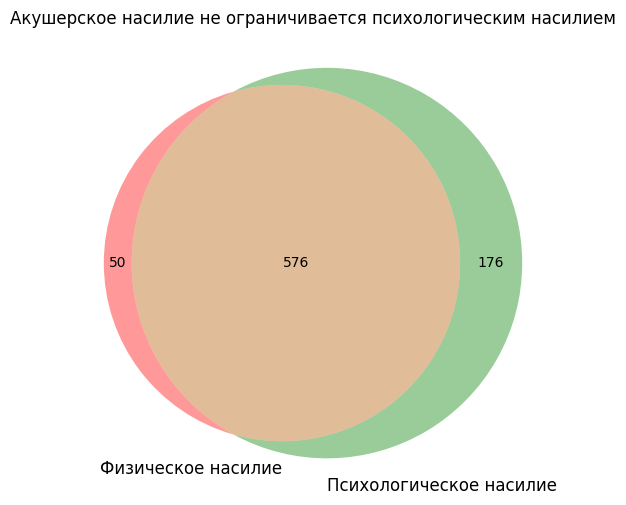

In [16]:
from matplotlib_venn import venn2

import matplotlib.pyplot as plt

# Calculate the sets
set_physical = set(df[df['violence_type'].str.contains('physical violence', na=False)].index)
set_non_physical = set(df[df['violence_type'].str.contains('psychological violence', na=False)].index)

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn2([set_physical, set_non_physical], ('Физическое насилие', 'Психологическое насилие'))

# Add title and show the plot
plt.title("Акушерское насилие не ограничивается психологическим насилием")
plt.show()

## Проверяем эмоции в постах

In [104]:
# Calculate the total emotion shares for each post
emotion_columns = list(emotion_lexicon.keys())
emotion_df = df[emotion_columns]
df['total_emotion_shares'] = df[emotion_columns].sum(axis=1)

# Count the number of posts with total emotion shares equal to 0
zero_emotion_posts = (df['total_emotion_shares'] == 0).sum()
print(f"Number of posts with total emotion shares equal to 0: {zero_emotion_posts}")

Number of posts with total emotion shares equal to 0: 45


In [110]:
emotion_df.describe()

,стыд,страх,боль,злость,одиночество,грусть,отвращение,радость,спокойствие
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,0.000647,0.005263,0.010405,0.000332,0.002715,0.000411,0.001572,0.001166,0.001040
std,0.002012,0.006737,0.009721,0.001719,0.003814,0.001594,0.003427,0.002745,0.002383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.003643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.003514,0.008730,0.000000,0.000336,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.007425,0.014969,0.000000,0.004482,0.000000,0.002376,0.001509,0.001434
max,0.024793,0.060606,0.111111,0.029851,0.029412,0.022989,0.047619,0.035714,0.030928


In [112]:
# emotion_columns = list(emotion_lexicon.keys())
emotion_columns.append('id')
emotion_columns.append('total_emotion_shares')
emotion_columns
emotion_df = df[emotion_columns]
emotion_df

,стыд,страх,боль,злость,одиночество,грусть,отвращение,радость,спокойствие,id,total_emotion_shares
0,0.000000,0.001942,0.011650,0.000000,0.005825,0.000000,0.000000,0.001942,0.001942,3538,0.023301
1,0.000000,0.002466,0.004932,0.000000,0.000000,0.000000,0.002466,0.000000,0.000000,3537,0.009864
2,0.000000,0.014563,0.009709,0.000000,0.004854,0.000000,0.000000,0.000000,0.000000,3536,0.029126
3,0.000000,0.007605,0.000000,0.003802,0.000000,0.007605,0.000000,0.000000,0.000000,3534,0.019011
4,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3533,0.011111
...,...,...,...,...,...,...,...,...,...,...,...
909,0.000000,0.003497,0.000000,0.000000,0.000000,0.000000,0.003497,0.003497,0.003497,20,0.013986
910,0.000000,0.000000,0.006024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18,0.006024
911,0.000000,0.000000,0.010152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,0.010152
912,0.002874,0.002874,0.000000,0.000000,0.020115,0.000000,0.000000,0.000000,0.000000,13,0.025862


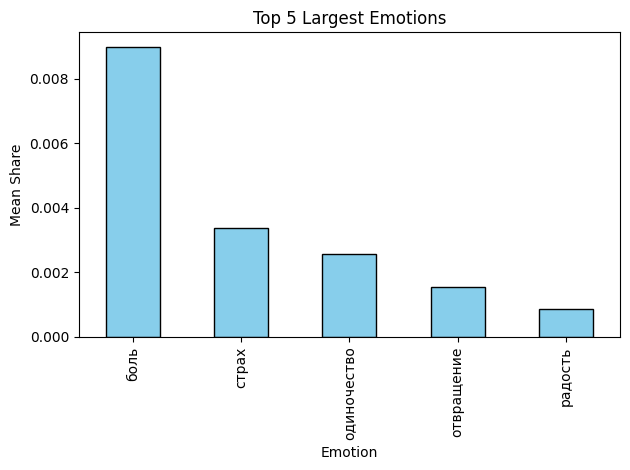

In [194]:
# Select the five largest emotions based on their mean values
top_5_emotions = mean_emotions.nlargest(5)

# Plot the bar chart
top_5_emotions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel("Mean Share")
plt.xlabel("Emotion")
plt.title("Top 5 Largest Emotions")
plt.tight_layout()
plt.show()

In [16]:
from collections import Counter

# Flatten the list of hashtags and count occurrences
all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in eval(hashtags)]
hashtag_counts = Counter(all_hashtags)

# Get the top unique hashtags
top_hashtags = hashtag_counts.most_common(11)  # Adjust the number as needed
print(top_hashtags)

[('#насилие_в_родах', 891), ('#ирония_унижение_обесценивание', 586), ('#игнор_просьб_о_помощи', 439), ('#игнор_боли', 417), ('#болезненный_осмотр', 311), ('#стимуляция_и_принуждение_к_ней', 303), ('#прокол_пузыря', 277), ('#эпизиотомия', 228), ('#нельзя_свободно_двигаться', 215), ('#выдавливание_кристеллер', 213), ('#клизма_бритьё', 211)]


# Сохраняем данные

In [109]:
df.to_csv('../output/detailed_data_with_emotions.csv', index=False)

In [119]:
emotion_df.to_csv('../output/emotion_df.csv', index=False)

In [117]:
mean_emotions.to_csv('../output/mean_emotions.csv', index=False)